**Text Clustering and
Topic Modeling**

In [2]:
#to view the data loaded from huggingface in a proper view format spreadsheet type sheet, we convert it to pd.datafram3, or otherwise just print(dataset[0])



# import torch

# # Set device once at the top
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(f"Using {device}")

# # When loading models
# model.to(device)

# # When passing data
# data = data.to(device)

In [3]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

# Set device to MPS (Apple GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Load dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstract = dataset["Abstracts"]
titles= dataset["Titles"]
# Load model and move it to GPU
embedding_model = SentenceTransformer("thenlper/gte-small")
embedding_model.to(device)  # This moves the model to MPS

# Encode using GPU
embeddings = embedding_model.encode(
    list(abstract),
    show_progress_bar=True,
    device=device.type  # <This is key
)


/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0720 07:54:21.208000 55889 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: mps


/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1405/1405 [08:09<00:00,  2.87it/s]


In [4]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [5]:
embeddings.shape

(44949, 384)

In [6]:
from umap import UMAP
umap_model=UMAP(
    n_components=5,min_dist=0.0,metric="cosine", random_state=42
)
reduce_embeddings=umap_model.fit_transform(embeddings)

/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
from hdbscan import HDBSCAN
hdbscan_model=HDBSCAN(min_cluster_size=50, metric='euclidean',cluster_selection_method="eom").fit(reduce_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
huggingface/tokenizers: The current process just got fork

In [8]:
clusters=hdbscan_model.labels_

In [9]:
len(set(clusters))

160

In [10]:
import numpy as np
cluster=22
for index in np.where(clusters==cluster)[0][:3]:
    print(abstract[int(index)][:300]+ "...\n")

  Since the late 1990s when speech companies began providing their
customer-service software in the market, people have gotten used to speaking to
machines. As people interact more often with voice and gesture controlled
machines, they expect the machines to recognize different emotions, and
underst...

  Perception and expression of emotion are key factors to the success of
dialogue systems or conversational agents. However, this problem has not been
studied in large-scale conversation generation so far. In this paper, we
propose Emotional Chatting Machine (ECM) that can generate appropriate
respo...

  Empathy, as defined in behavioral sciences, expresses the ability of human
beings to recognize, understand and react to emotions, attitudes and beliefs of
others. The lack of an operational definition of empathy makes it difficult to
measure it. In this paper, we address two related problems in au...



In [11]:
import pandas as pd
reduce_embeddings=UMAP(n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

df=pd.DataFrame(reduce_embeddings,columns=['x','y'])
df["title"]= titles
df["cluster"]=[str(c) for c in clusters]

clusters_df= df.loc[df.cluster != "-1", :]
outliers_df=df.loc[df.cluster == "-1", :]

/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-8.84580488204956, 11.425997447967529, -8.40596239566803, 11.39526550769806)

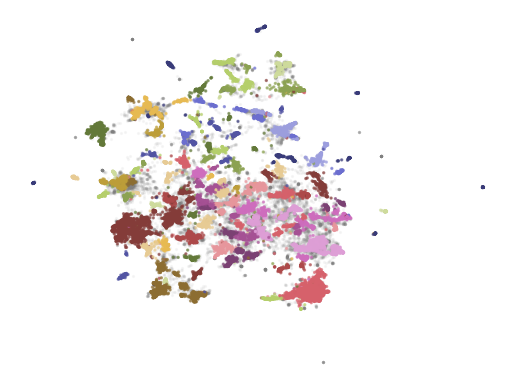

In [12]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y,alpha=0.05,s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y,c=clusters_df.cluster.astype(int),alpha=0.6, s=2,cmap="tab20b"

)
plt.axis("off")

visually appealing maybe but definitely not of much use so we move onto topic modelling

In [13]:
from bertopic import BERTopic

topic_model=BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstract,embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-07-20 08:03:34,481 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-20 08:03:53,239 - BERTopic - Dimensionality - Completed ✓
2025-07-20 08:03:53,240 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-20 08:03:53,763 - BERTopic - Cluster - Completed ✓
2025-07-20 08:03:53,769 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-20 08:03:55,042 - BERTopic - Representation - Completed ✓


In [14]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14882                               -1_the_of_and_to   
1        0   2154                 0_question_qa_questions_answer   
2        1   2115                   1_speech_asr_recognition_end   
3        2    921  2_summarization_summaries_summary_abstractive   
4        3    716               3_translation_nmt_machine_neural   
..     ...    ...                                            ...   
155    154     52                154_mixed_code_sentiment_mixing   
156    155     51   155_diffusion_generation_autoregressive_text   
157    156     51          156_arabic_sentiment_analysis_dialect   
158    157     50    157_counseling_therapy_mental_psychotherapy   
159    158     50     158_coherence_discourse_paragraph_cohesion   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, qa, questions, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [summarization, summaries, summary, abstractiv...   
4    [translation, nmt, machine, neural, bleu, reso...   
..                                                 ...   
155  [mixed, code, sentiment, mixing, analysis, eng...   
156  [diffusion, generation, autoregressive, text, ...   
157  [arabic, sentiment, analysis, dialect, msa, as...   
158  [counseling, therapy, mental, psychotherapy, h...   
159  [coherence, discourse, paragraph, cohesion, te...   

                                   Representative_Docs  
0    [  Deep learning approaches are superior in NL...  
1    [  We propose a novel text generation task, na...  
2    [  We introduce Wav2Seq, the first self-superv...  
3    [  Data-driven approaches to sequence-to-seque...  
4    [  Neural Machine Translation (NMT) has obtain...  
..                                                 ...  
155  [  The usage of more than one language in the ...  
156  [  Diffusion models have achieved great succes...  
157  [  The social media network phenomenon leads t...  
158  [  Mental health care poses an increasingly se...  
159  [  While there has been significant progress t...  

[160 rows x 5 columns]

In [50]:
topic_model.get_topic(3)

[('Neural machine translation', 1),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0)]

In [16]:
topic_model.find_topics("topic")

([26, -1, 55, 115, 0], [0.8853905, 0.85303956, 0.852934, 0.8528288, 0.849072])

In [17]:
topic_model.get_topic_info(26)

Topic  Count                        Name  \
0     26    246  26_topic_topics_lda_latent   

                                      Representation  \
0  [topic, topics, lda, latent, document, documen...   

                                 Representative_Docs  
0  [  Topic models jointly learn topics and docum...

In [18]:
fig= topic_model.visualize_documents(
    list(titles),
    reduced_embeddings=reduce_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [24]:
topic_model.visualize_barchart()

topic_model.visualize_heatmap(n_clusters=30)

topic_model.visualize_hierarchy()

one limitation- only using bag of words so missing a lot of semantic structures, but they are fast so we use them then follow up with embedding model on it which is slower---RERANK the topics only...so less compute and slow is fine then and more work done

In [25]:
from copy import deepcopy
original_topics= deepcopy(topic_model.topic_representations_)

In [33]:
def topic_differences(model, original_topics, nr_topics=5):

    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic","Original","Updated"])
    for topic in range(nr_topics):
 # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5]) #see carefully where to put which bracket
        df.loc[len(df)] = [topic, og_words, new_words]
    return df
    

first we try KeyBERTinspired--- it takes average embeddings from the document's embeddings and does a cosine similarity with the keyword embeddings to rerank them//


In [32]:
from bertopic.representation import KeyBERTInspired
representation_model= KeyBERTInspired()
topic_model.update_topics(abstract, representation_model=representation_model)

#show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3        translation | nmt | machine | neural | bleu   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  answering | questions | comprehension | retrie...  
1      phonetic | language | speech | voice | spoken  
2  summarization | summarizers | summaries | summ...  
3  translation | translating | translate | transl...  
4       gendered | gender | bias | biases | pronouns

topics offer more clarity but abbreviations like nmt get removed

also the redundancy is still there like summary and summaries, that limits the clarity--- MMR comes in..

In [34]:
from bertopic.representation import MaximalMarginalRelevance

representation_model= MaximalMarginalRelevance()
topic_model.update_topics(abstract, representation_model= representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3        translation | nmt | machine | neural | bleu   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  retrieval | comprehension | hop | knowledge | ...  
1                 speech | asr | audio | wer | model  
2  summarization | summaries | abstractive | eval...  
3  translation | nmt | neural | english | multili...  
4      gender | bias | biases | debiasing | fairness

In [36]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt="""i have a topic that contains the following documents: '[DOCUMENTS]'
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and the keywords, what is the topic about?"""

generator=pipeline("text2text-generation", model= "google/flan-T5-small")

representation_model=TextGeneration(generator, prompt=prompt, doc_length=50, tokenizer="whitespace")
topic_model.update_topics(abstract, representation_model=representation_model)

100%|██████████| 160/160 [00:11<00:00, 14.19it/s]


In [38]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3        translation | nmt | machine | neural | bleu   
4      4      gender | bias | biases | debiasing | fairness   

                                    Updated  
0            question answering |  |  |  |   
1  automatic speech recognition |  |  |  |   
2                 Summarization |  |  |  |   
3    Neural machine translation |  |  |  |   
4                   gender bias |  |  |  |

In [ ]:
import google.generativeai as genai
from dotenv import load_dotenv
import os


load_dotenv()

api_key=os.getenv("gemini_api_key")
genai.configure(api_key=api_key)

model=genai.GenerativeModel("gemini-2.5-pro")
response=model.generate_content("who are you?")


In [40]:
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "I am a large language model, trained by Google."
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "index": 0
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 5,
        "candidates_token_count": 11,
        "total_token_count": 993
      },
      "model_version": "gemini-2.5-pro"
    }),
)

In [ ]:
#copilot generated, bertopic is not smooth with gemini

from bertopic.representation._base import BaseRepresentation

class GeminiRepresentation(BaseRepresentation):
	def __init__(self, model, prompt_template):
		self.model = model
		self.prompt_template = prompt_template

	def __call__(self, documents, topic_words, **kwargs):
		# Prepare the prompt
		doc_text = "\n".join(documents)
		keywords = " | ".join([w for w, _ in topic_words])
		prompt = self.prompt_template.replace("[DOCUMENTS]", doc_text).replace("[KEYWORDS]", keywords)
		response = self.model.generate_content(prompt)
		# Extract the topic label from the response
		label = response.text.strip()
		# Return as list of tuples as expected by BERTopic
		return [(label, 1.0)]

prompt = ()

representation_model = GeminiRepresentation(model, prompt)
topic_model.update_topics(abstract, representation_model=representation_model)

In [64]:
topic_differences(topic_model ,original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3        translation | nmt | machine | neural | bleu   
4      4      gender | bias | biases | debiasing | fairness   

                                    Updated  
0            question answering |  |  |  |   
1  automatic speech recognition |  |  |  |   
2                 Summarization |  |  |  |   
3    Neural machine translation |  |  |  |   
4                   gender bias |  |  |  |

In [ ]:
# Your documents (abstracts)
abstracts = abstract

# Keywords for each document (if applicable)
keywords=topic_model.get_topics()
keywords_list = keywords

# Function to get topic label using Gemini
def get_topic_label(documents, keywords):
    prompt = f"""
    I have a topic that contains the following documents:
    {documents}

    The topic is described by the following keywords: {keywords}

    Based on the information above, extract a short topic label in
    the following format:
    topic: <short topic label>
    """
    response = model.generate_content(prompt)
    return response.text.strip()

# Update topics
new_topics = []
for doc, keywords in zip(titles, keywords_list):
    topic_label = get_topic_label(doc, keywords)
    new_topics.append(topic_label)

# Assuming your topic_model stores topics as a list:
topic_model.topics = new_topics  # Or whatever method your class uses to store topics

# Optionally, compare to original topics:
print("Updated Topics:", new_topics)
